# 1. Import necessary libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.inspection import PartialDependenceDisplay


# 2. Generate synthetic data
We create a dataset where the relevance of the features is known beforehand.
   - X1: Strong non-linear effect (a sine wave)
   - X2: Weak linear effect
   - X3: No effect (irrelevant feature)


In [2]:

# Set a seed for reproducibility
np.random.seed(42)

# Create 100 data points with 3 features
feature_names = ["X1 (Strong Effect)", "X2 (Weak Effect)", "X3 (No Effect)"]
X = np.random.rand(100, 3) * 10

# Define the relationship between features and the target 'y'
# y = 3 * sin(X1) + 0.2 * X2 + noise
y = (3 * np.sin(X[:, 0]) +       # Strong effect from X1
     0.2 * X[:, 1] +           # Weak effect from X2
     np.random.randn(100))     # Noise, no contribution from X3



# 3. Define the Gaussian Process kernel with ARD
To enable ARD, we provide an initial length_scale for each dimension.
scikit-learn's RBF kernel will use ARD if length_scale is an array.
The number of elements in the array must match the number of features.
We also include a ConstantKernel to learn the signal variance.


In [5]:

# Initial length_scale is a vector of 1s, one for each of the 3 features.
# The bounds encourage the optimizer to explore a wide range of values.
ard_kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * X.shape[1], length_scale_bounds=(1e-2, 1e4))



# 4. Create and fit the Gaussian Process model
n_restarts_optimizer is crucial for finding the global maximum of the
log-marginal-likelihood, preventing the model from getting stuck in a
poor local optimum.


In [6]:

gp_model = GaussianProcessRegressor(
    kernel=ard_kernel,
    n_restarts_optimizer=15, # Use a good number of restarts
    alpha=1e-2,              # Corresponds to the noise level, can help with stability
    random_state=42
)

# Fit the model to the data
print("Fitting the GP model...")
gp_model.fit(X, y)
print("Fit complete.\n")


Fitting the GP model...
Fit complete.




# 5. Extract and interpret the learned ARD length-scales


In [7]:

print(f"Final Optimized Kernel: {gp_model.kernel_}\n")

# The learned parameters are part of the kernel object after fitting.
# The RBF kernel is the second part of our product kernel (k2).
learned_length_scales = gp_model.kernel_.k2.length_scale

print("--- Automatic Relevance Determination (ARD) Results ---")
print("Recall: A SMALL length-scale implies HIGH relevance.\n")

for i, length_scale in enumerate(learned_length_scales):
    print(f"Learned length-scale for Feature X{i+1}: {length_scale:.4f}")

# Find the most and least relevant features based on the learned values
most_relevant_feature_index = np.argmin(learned_length_scales)
least_relevant_feature_index = np.argmax(learned_length_scales)

print("\n--- Interpretation ---")
print(f"The model identified Feature X{most_relevant_feature_index + 1} as the MOST relevant (smallest length-scale).")
print(f"The model identified Feature X{least_relevant_feature_index + 1} as the LEAST relevant (largest length-scale).")

Final Optimized Kernel: 2.44**2 * RBF(length_scale=[0.286, 3.5, 3.64])

--- Automatic Relevance Determination (ARD) Results ---
Recall: A SMALL length-scale implies HIGH relevance.

Learned length-scale for Feature X1: 0.2864
Learned length-scale for Feature X2: 3.5012
Learned length-scale for Feature X3: 3.6434

--- Interpretation ---
The model identified Feature X1 as the MOST relevant (smallest length-scale).
The model identified Feature X3 as the LEAST relevant (largest length-scale).


# 6. Generate and display Partial Dependence Plots



Generating Partial Dependence Plots...
Displaying plots. Close the plot window to continue.


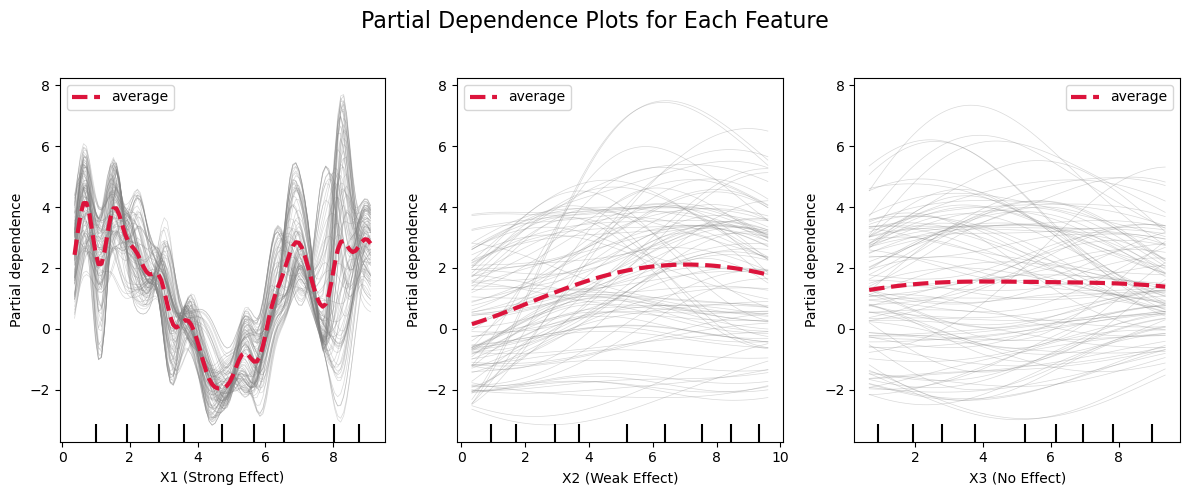


--- PDP Interpretation ---
1. Plot for 'X1 (Strong Effect)': Shows a clear sinusoidal curve, correctly capturing the strong, non-linear relationship.
2. Plot for 'X2 (Weak Effect)': Shows a gentle upward slope, correctly identifying the weak linear relationship.
3. Plot for 'X3 (No Effect)': Is almost completely flat, correctly showing that this feature has no impact on the model's predictions.


In [9]:

print("\nGenerating Partial Dependence Plots...")

# Create a figure and axes for the plots
fig, ax = plt.subplots(figsize=(12, 5), ncols=3)
fig.suptitle('Partial Dependence Plots for Each Feature', fontsize=16)

# The 'features' argument specifies which feature indices to plot.
# We will plot all three features.
# The 'line_kw' customizes the appearance of the PDP line.
# The 'ice_lines_kw' customizes the Individual Conditional Expectation lines (optional).
display = PartialDependenceDisplay.from_estimator(
    gp_model,
    X,
    features=[0, 1, 2],  # Indices of features to plot
    feature_names=feature_names, # Names for the plot axes
    ax=ax,
    line_kw={"color": "crimson", "linewidth": 3},
    ice_lines_kw={"color": "gray", "alpha": 0.3, "linewidth": 0.5},
    kind="both" # 'both' shows the PDP and individual ICE lines
)

fig.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for suptitle

# Show the plot
print("Displaying plots. Close the plot window to continue.")
plt.show()

print("\n--- PDP Interpretation ---")
print("1. Plot for 'X1 (Strong Effect)': Shows a clear sinusoidal curve, correctly capturing the strong, non-linear relationship.")
print("2. Plot for 'X2 (Weak Effect)': Shows a gentle upward slope, correctly identifying the weak linear relationship.")
print("3. Plot for 'X3 (No Effect)': Is almost completely flat, correctly showing that this feature has no impact on the model's predictions.")